In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install --q japanize_matplotlib
import japanize_matplotlib

%matplotlib inline
plt.style.use("ggplot")

! pip install --q plotly
import plotly.graph_objects as go
import plotly.express as px

from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

In [2]:
query = """
WITH base AS(
  SELECT salesday, storecd, posid.customercd, SUM(internalobjtax) AS sale_amt, age, sex, FORMAT_DATE("%y-%m", salesday) AS ym2, COUNT(posno) AS raiten
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` i
  ON posid.customercd = i.customercd
  WHERE salesday BETWEEN "2023-03-01" AND "2023-08-31"
  AND posid.customercd <> "0"
  GROUP BY salesday, storecd, posid.customercd, age, sex
),
-- 生鮮一番店とライフステージデータを作る
lifestage_seisen AS 
(
  SELECT ym, customer_id,
    CASE
      WHEN single = "1" THEN "単身"
      WHEN dewks = "1" THEN "DEWKS"
      WHEN dinks = "1" THEN "DINKS"
      WHEN elderly_couple = "1" THEN "老年夫婦"
  ELSE "不明"
  END AS lifestage,
    CASE
      WHEN trial_fresh_fan = "1" THEN "生鮮一番店"
      ELSE "生鮮一番以外"
    END AS trial_fresh,
    FORMAT_DATE("%y-%m", ym) AS ym2
  FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` 

  WHERE ym >= "2022-01-01"
),
result AS(
  SELECT salesday, base.ym2, base.storecd, 
        storename, blockname, store_format_name,
        customercd, age, sex, lifestage, trial_fresh, sale_amt, raiten
  FROM base
  JOIN lifestage_seisen
  ON lifestage_seisen.customer_id = base.customercd
  AND lifestage_seisen.ym2 = base.ym2
  INNER JOIN `inunaki.dim_common_0001.dim_store` store 
  ON base.storecd = store.storecd
  LEFT JOIN `inunaki.dim_org_0001.dim_branches` a
  ON base.storecd = a.store_cd
  LEFT JOIN `inunaki.dim_org_0001.dim_branch_format` b
  ON a.store_format_cd = b.store_format_cd
)
SELECT ym2, storecd, 
       storename, blockname, store_format_name,
       customercd, age, sex, lifestage, trial_fresh, SUM(sale_amt) AS sale_amt, SUM(raiten) AS ranten
FROM result
GROUP BY  ym2, storecd, 
       storename, blockname, store_format_name,
       customercd, age, sex, lifestage, trial_fresh
"""

df_zentai = client.query(query).to_dataframe()

In [3]:
# query = """
# WITH base AS(
#   SELECT salesday, storecd, posid.customercd, SUM(salesamount) AS sale_amt, SUM(salescnt) AS cnt,age, sex, FORMAT_DATE("%y-%m", salesday) AS ym2,  divisionname, organizationname
#   FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid
#   LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` i
#   ON posid.customercd = i.customercd
#   INNER JOIN `inunaki.dim_common_0001.dim_product` product 
#   ON posid.jan = product.jan
#   WHERE salesday BETWEEN "2023-03-01" AND "2023-08-31"
#   GROUP BY salesday, storecd, posid.customercd, age, sex, divisionname, organizationname
# ),

# -- 生鮮一番店とライフステージデータを作る
# lifestage_seisen AS 
# (
#   SELECT ym, customer_id,
#     CASE
#       WHEN single = "1" THEN "単身"
#       WHEN dewks = "1" THEN "DEWKS"
#       WHEN dinks = "1" THEN "DINKS"
#       WHEN elderly_couple = "1" THEN "老年夫婦"
#   ELSE "不明"
#   END AS lifestage,
#     CASE
#       WHEN trial_fresh_fan = "1" THEN "生鮮一番店"
#       ELSE "生鮮一番以外"
#     END AS trial_fresh,
#     FORMAT_DATE("%y-%m", ym) AS ym2
#   FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` 

#   WHERE ym >= "2022-01-01"
# ),
# result AS(
#   SELECT salesday, base.ym2, base.storecd, 
#         storename, blockname, store_format_name,
#         customercd, age, sex, lifestage, trial_fresh, sale_amt, divisionname, organizationname, cnt
#   FROM base
#   JOIN lifestage_seisen
#   ON lifestage_seisen.customer_id = base.customercd
#   AND lifestage_seisen.ym2 = base.ym2
#   INNER JOIN `inunaki.dim_common_0001.dim_store` store 
#   ON base.storecd = store.storecd
#   LEFT JOIN `inunaki.dim_org_0001.dim_branches` a
#   ON base.storecd = a.store_cd
#   LEFT JOIN `inunaki.dim_org_0001.dim_branch_format` b
#   ON a.store_format_cd = b.store_format_cd
# )
# SELECT 
#        customercd, age, sex, lifestage, SUM(sale_amt) AS sale_amt, SUM(cnt) AS cnt,divisionname, organizationname, COUNT(salesday) AS kounyu_count
# FROM result
# GROUP BY  
#        customercd, age, sex, lifestage, divisionname, organizationname
# """

# # #データフレームに変換
# df = client.query(query).to_dataframe()

# query = """
# WITH base AS(
#   SELECT salesday, storecd, posid.customercd, SUM(salesamount) AS sale_amt, SUM(salescnt) AS cnt,age, sex, FORMAT_DATE("%y-%m", salesday) AS ym2,  
#          divisionname, organizationname, posid.jan, janname, linename, departmentname, categoryname
#   FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid
#   LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` i
#   ON posid.customercd = i.customercd
#   INNER JOIN `inunaki.dim_common_0001.dim_product` product 
#   ON posid.jan = product.jan
#   WHERE salesday BETWEEN "2023-03-01" AND "2023-08-31"
#   AND storecd = 473
#   AND posid.customercd <> "0"
#   GROUP BY salesday, storecd, posid.customercd, age, sex, divisionname, organizationname, posid.jan, janname, linename, departmentname, categoryname
# ),

# -- 生鮮一番店とライフステージデータを作る
# lifestage_seisen AS 
# (
#   SELECT ym, customer_id,
#     CASE
#       WHEN single = "1" THEN "単身"
#       WHEN dewks = "1" THEN "DEWKS"
#       WHEN dinks = "1" THEN "DINKS"
#       WHEN elderly_couple = "1" THEN "老年夫婦"
#   ELSE "不明"
#   END AS lifestage,
#     CASE
#       WHEN trial_fresh_fan = "1" THEN "生鮮一番店"
#       ELSE "生鮮一番以外"
#     END AS trial_fresh,
#     FORMAT_DATE("%y-%m", ym) AS ym2
#   FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` 

#   WHERE ym >= "2022-01-01"
# )--,
# -- result AS(
#   SELECT salesday, base.ym2, base.storecd, 
#         storename, blockname, store_format_name,
#         customercd, age, sex, lifestage, trial_fresh, divisionname, organizationname, linename, departmentname, categoryname,  jan, janname, cnt, sale_amt
#   FROM base
#   JOIN lifestage_seisen
#   ON lifestage_seisen.customer_id = base.customercd
#   AND lifestage_seisen.ym2 = base.ym2
#   INNER JOIN `inunaki.dim_common_0001.dim_store` store 
#   ON base.storecd = store.storecd
#   LEFT JOIN `inunaki.dim_org_0001.dim_branches` a
#   ON base.storecd = a.store_cd
#   LEFT JOIN `inunaki.dim_org_0001.dim_branch_format` b
#   ON a.store_format_cd = b.store_format_cd
# -- )
# -- SELECT 
# --        customercd, age, sex, lifestage, SUM(sale_amt) AS sale_amt, SUM(cnt) AS cnt,divisionname, organizationname, COUNT(salesday) AS kounyu_count
# -- FROM result
# -- GROUP BY  
# --        customercd, age, sex, lifestage, divisionname, organizationname
# """

# # #データフレームに変換
# df = client.query(query).to_dataframe()

### 洗い出し
- 売上金額高い
- 来店回数が多い
- 購入カテゴリが多い
- **ロックオンカテゴリが多い**

In [4]:
df_zentai.head()

,ym2,storecd,storename,blockname,store_format_name,customercd,age,sex,lifestage,trial_fresh,sale_amt,ranten
0,23-03,307,トライウェル大子店,Ｄ栃木西,SMART,7100eb53d6e79c8387268ac6df374f41,40.0,0.0,単身,生鮮一番以外,2984,3
1,23-08,346,トライウェル矢板店,Ｄ栃木西,SMART,42931857bee53767c448530983ca1522,35.0,1.0,DEWKS,生鮮一番以外,7763,12
2,23-08,307,トライウェル大子店,Ｄ栃木西,SMART,cfb197f8e4da999374b0f53a76b2b8e1,65.0,1.0,単身,生鮮一番以外,8381,5
3,23-03,364,名取店,名取,SuC,826cb25f5ab22464c67446e0a22c531e,45.0,0.0,DINKS,生鮮一番以外,696,3
4,23-08,335,トライウェル馬頭店,Ｄ栃木西,SMART,fbfc767e137b9851b758216d34ce9ac6,50.0,1.0,単身,生鮮一番以外,4557,5


In [5]:
def sales_rank(x):
    if x >= 40000:
        return "ヘビー"
    elif x >= 20000:
        return "ミドル"
    elif x >= 10000:
        return "ライト"
    else:
        return "エントリ"

In [6]:
df_tmp = df_zentai.groupby(["ym2","customercd"]).agg({"sale_amt":"sum"}).reset_index()
df_tmp = df_tmp.groupby(["customercd"]).agg({"sale_amt":"mean"})
df_tmp = df_tmp.query("customercd!='0'")

df_tmp["rank"] = df_tmp["sale_amt"].apply(sales_rank)

In [7]:
df_store = df_zentai.groupby(["storename","customercd"]).agg({"ranten":"mean"}).reset_index()
df_store = df_store.query("customercd!='0'")

df_store = df_store.sort_values("ranten",ascending=False).groupby(["customercd"]).head(1)

In [8]:
# どこでよく買っているかと全体金額平均をマージする
df_result = df_tmp.merge(df_store,on="customercd")

In [67]:
df_rank_count = df_result.groupby(["storename","rank"]).agg({"customercd":"count","sale_amt":"sum"}).reset_index()
df_rank_count = pd.pivot_table(df_rank_count, index="storename",columns="rank",values="customercd",aggfunc="sum").reset_index()

df_rank_count["ヘビーミドル人数"] = df_rank_count["ヘビー"] + df_rank_count["ミドル"]
df_rank_count["合計人数"] = df_rank_count["ライト"] + df_rank_count["エントリ"] + df_rank_count["ヘビー"] + df_rank_count["ミドル"]
df_rank_count["ヘビーミドル率"] = round(df_rank_count["ヘビーミドル人数"] / df_rank_count["合計人数"] * 100, 2)

# 店舗情報を作る
df_tenpo_joho = df_zentai[["storecd","storename","blockname","store_format_name"]].drop_duplicates()

df_rank_count = df_tenpo_joho.merge(df_rank_count,on="storename")

In [77]:
df_rank_count = df_rank_count.query("storecd!=350")

In [74]:
# 売上金額について
df_amt_data = round(df_result.groupby(["storename"]).agg({"sale_amt":"sum"}).reset_index(),1)

In [68]:
df_rank_count.sort_values('ヘビーミドル率').query("store_format_name=='SuC'").describe()

,storecd,エントリ,ヘビー,ミドル,ライト,ヘビーミドル人数,合計人数,ヘビーミドル率
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,304.104046,12023.942197,897.283237,2649.017341,4883.184971,3546.300578,20453.427746,17.847572
std,144.070399,3673.211059,380.071728,753.000143,1305.979816,1099.332774,5238.497731,5.604911
min,5.000000,4189.000000,132.000000,752.000000,2046.000000,884.000000,10524.000000,6.990000
25%,175.000000,9506.000000,641.000000,2192.000000,4048.000000,2855.000000,16773.000000,14.190000
50%,331.000000,11736.000000,827.000000,2587.000000,4811.000000,3441.000000,20427.000000,16.600000
75%,415.000000,14204.000000,1046.000000,3005.000000,5593.000000,4062.000000,23289.000000,20.120000
max,555.000000,22583.000000,2245.000000,5479.000000,8479.000000,7724.000000,34387.000000,40.300000


In [78]:
df_rank_count.merge(df_amt_data,on="storename").sort_values('ヘビーミドル率').query("store_format_name=='SuC'").style.background_gradient(cmap='Reds')

,storecd,storename,blockname,store_format_name,エントリ,ヘビー,ミドル,ライト,ヘビーミドル人数,合計人数,ヘビーミドル率,sale_amt
211,383,隼人店,鹿児島,SuC,15907,362,1450,4100,1812,21819,8.300000,189861777.700000
165,60,北茨城店,北茨城,SuC,12290,260,1174,3085,1434,16809,8.530000,146214394.600000
184,256,和泉店,大阪南,SuC,11286,295,1188,2989,1483,15758,9.410000,142613043.500000
69,469,関店,岐阜,SuC,15304,394,1644,4257,2038,21599,9.440000,197168882.100000
257,175,笠懸店,群馬埼玉北,SuC,9137,259,953,2291,1212,12640,9.590000,112886535.400000
212,344,東開店,鹿児島,SuC,22583,592,2612,7125,3204,32912,9.740000,317648893.000000
30,90,東岡山店,兵庫,SuC,11611,332,1324,3225,1656,16492,10.040000,154050979.100000
2,364,名取店,名取,SuC,18579,500,2199,5435,2699,26713,10.100000,251693042.400000
133,477,帯広東店,道東,SuC,19863,546,2533,6455,3079,29397,10.470000,285071623.000000
130,490,かすみがうら店,茨城,SuC,15251,431,1899,4597,2330,22178,10.510000,210323757.200000


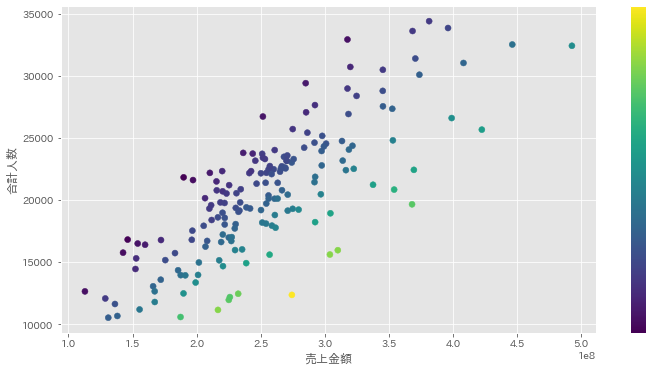

In [104]:
# 合計人数	ヘビーミドル率	sale_amt
data = df_rank_count.merge(df_amt_data,on="storename").query("store_format_name=='SuC'")
# sns.scatterplot(x=data["sale_amt"],y=data["合計人数"])
plt.figure(figsize=(12,6))
plt.scatter(data["sale_amt"], data["合計人数"], c=data["ヘビーミドル率"])
plt.xlabel('売上金額')
plt.ylabel('合計人数')
# カラーバーを表示
plt.colorbar(ticks=np.arange(0, 1, 0.1))
plt.show()

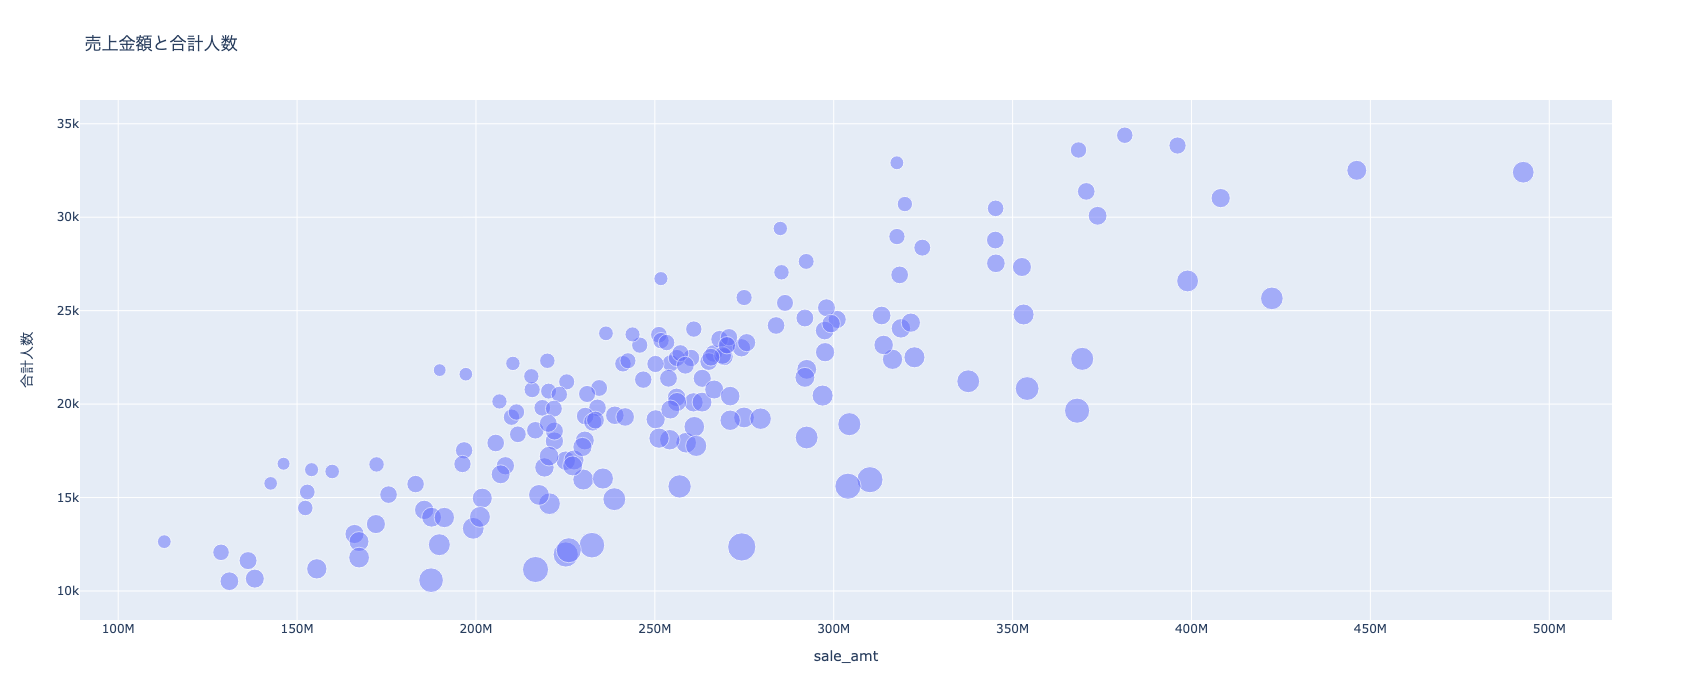

In [100]:
data2 = data[["sale_amt","合計人数","ヘビーミドル率"]]
# バブルチャートを描画
fig = px.scatter(data2, x='sale_amt', y='合計人数', size='ヘビーミドル率', title='売上金額と合計人数')
fig.update_traces(marker=dict(opacity=0.5))

# グラフのサイズを設定
fig.update_layout(
    width=1200,  # 幅を設定（ピクセル単位）
    height=700  # 高さを設定（ピクセル単位）
)

# グラフを表示
fig.show()

In [13]:
df_customer = df_zentai[["storecd","storename","customercd","age","sex","lifestage"]].drop_duplicates()

In [14]:
df_tmp2 = df_customer.query("storename=='隼人店'")
df_tmp2 = df_tmp2.groupby(["lifestage"]).agg({"customercd":"count"}).reset_index()
df_tmp2["合計人数"] = df_tmp2["customercd"].sum()
df_tmp2["比率"] = round(df_tmp2["customercd"] / df_tmp2["合計人数"] * 100, 2)
df_tmp2.sort_values("比率",ascending=False)

,lifestage,customercd,合計人数,比率
3,単身,8310,33638,24.70
2,不明,8242,33638,24.50
1,DINKS,5947,33638,17.68
0,DEWKS,5704,33638,16.96
4,老年夫婦,5435,33638,16.16


In [15]:
df_tmp2 = df_customer.query("storename=='東開店'")
df_tmp2 = df_tmp2.groupby(["lifestage"]).agg({"customercd":"count"}).reset_index()
df_tmp2["合計人数"] = df_tmp2["customercd"].sum()
df_tmp2["比率"] = round(df_tmp2["customercd"] / df_tmp2["合計人数"] * 100, 2)
df_tmp2.sort_values("比率",ascending=False)

,lifestage,customercd,合計人数,比率
3,単身,11231,47869,23.46
2,不明,11207,47869,23.41
1,DINKS,9401,47869,19.64
0,DEWKS,8066,47869,16.85
4,老年夫婦,7964,47869,16.64


In [16]:
df_tmp2 = df_rank_count.query("store_format_name=='SuC'").query("ヘビーミドル率>=16")[["storename"]].drop_duplicates()
df_tmp2 = df_customer.merge(df_tmp2,on="storename")
df_tmp2 = df_tmp2.groupby(["lifestage"]).agg({"customercd":"count"}).reset_index()
df_tmp2["合計人数"] = df_tmp2["customercd"].sum()
df_tmp2["比率"] = round(df_tmp2["customercd"] / df_tmp2["合計人数"] * 100, 2)
df_tmp2.sort_values("比率",ascending=False)

,lifestage,customercd,合計人数,比率
0,DEWKS,892449,3773617,23.65
4,老年夫婦,853288,3773617,22.61
3,単身,777097,3773617,20.59
1,DINKS,674522,3773617,17.87
2,不明,576261,3773617,15.27


In [17]:
df_rank_count.sort_values('ヘビーミドル率').query("blockname=='鹿児島'")

,storecd,storename,blockname,store_format_name,エントリ,ヘビー,ミドル,ライト,ヘビーミドル人数,合計人数,ヘビーミドル率
212,383,隼人店,鹿児島,SuC,15907,362,1450,4100,1812,21819,8.30
213,344,東開店,鹿児島,SuC,22583,592,2612,7125,3204,32912,9.74
214,419,出水黄金店,鹿児島,SuC,15375,482,2258,5613,2740,23728,11.55
211,407,鹿屋店,鹿児島,SuC,17328,641,2623,6461,3264,27053,12.07


客数と売上金額についてみてみる

In [42]:
# 全体の構成について
df_tmp = df_zentai.query("ym2=='23-08'").groupby(["customercd"]).agg({"sale_amt":"sum"})
df_tmp = df_tmp.reset_index()
df_tmp["rank"] = df_tmp["sale_amt"].apply(sales_rank)

# ランクの売上構成比
df_rank_amt = df_tmp.groupby(["rank"]).agg({"sale_amt":"sum","customercd":"count"}).reset_index()
df_rank_amt["売上構成比"] = round(df_rank_amt["sale_amt"] / df_rank_amt["sale_amt"].sum()*100, 2)
df_rank_amt["人数構成比"] = round(df_rank_amt["customercd"] / df_rank_amt["customercd"].sum()*100, 2)

df_rank_amt = df_rank_amt.rename(columns={"rank":"ランク","sale_amt":"売上金額","customercd":"人数"})

In [43]:
df_rank_amt.sort_values("売上構成比",ascending=False)

,ランク,売上金額,人数,売上構成比,人数構成比
2,ミドル,16786243056,604559,31.88,16.71
1,ヘビー,14550696573,243823,27.64,6.74
3,ライト,12439820862,869270,23.63,24.02
0,エントリ,8872459970,1900975,16.85,52.53


In [55]:
a = df_rank_amt.query("ランク=='ミドル'")[["人数構成比"]].iloc[0,0] + df_rank_amt.query("ランク=='ヘビー'")[["人数構成比"]].iloc[0,0]
b = df_rank_amt.query("ランク=='ミドル'")[["売上構成比"]].iloc[0,0] + df_rank_amt.query("ランク=='ヘビー'")[["売上構成比"]].iloc[0,0]
print(f"ヘビー・ミドルの人数構成比:{a:.2f}%")
print(f"ヘビー・ミドルの売上構成比:{b:.2f}%")

ヘビー・ミドルの人数構成比:23.45%
ヘビー・ミドルの売上構成比:59.52%


In [58]:
a = df_zentai[["customercd","lifestage","trial_fresh"]].drop_duplicates()

In [62]:
a["lifestage"].value_counts().reset_index().sort_values("lifestage",ascending=False)

,index,lifestage
0,単身,1717251
1,老年夫婦,1653165
2,不明,1482881
3,DEWKS,1443383
4,DINKS,1319298


In [64]:
a["trial_fresh"].value_counts().reset_index().sort_values("trial_fresh",ascending=False)

,index,trial_fresh
0,生鮮一番以外,6324530
1,生鮮一番店,1291448
